# Прогнозирование индекса селективности (SI) соединений

## 1. Введение

В данном проекте мы решаем задачу регрессии для прогнозирования **индекса селективности (SI)** химических соединений. Индекс селективности является важным показателем в фармакологии, отражающим, насколько избирательно соединение действует на клетки-мишени (например, раковые) по сравнению со здоровыми клетками. Высокий SI указывает на потенциально более безопасный и эффективный препарат.

**Цель проекта:**
1. Исследовать предоставленные данные.
2. Построить и сравнить несколько моделей машинного обучения для прогнозирования SI.
3. Настроить гиперпараметры для лучших моделей.
4. Сделать выводы о применимости различных методов и дать рекомендации по улучшению.

## 2. Импорт библиотек

Загрузим все необходимые библиотеки для анализа данных, моделирования и визуализации.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для лучшего отображения
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## 3. Загрузка и первичный анализ данных (EDA)

In [4]:
df = pd.read_excel('data.xlsx', index_col=0)
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (1001, 213)


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,...,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Анализ целевой переменной

Целевой переменной является `SI`. Изучим ее распределение.

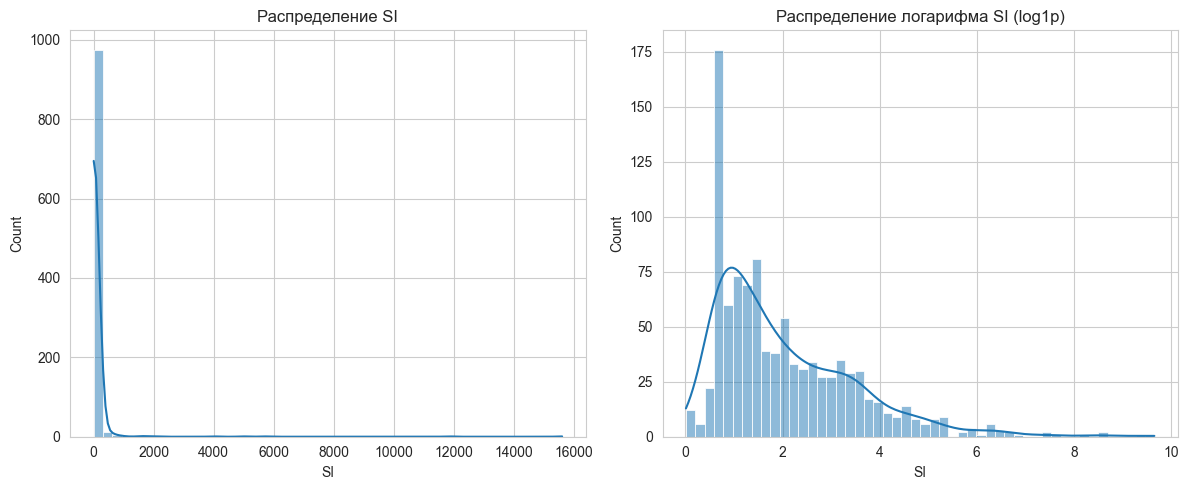

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['SI'], bins=50, kde=True)
plt.title('Распределение SI')

# Из-за сильного смещения вправо, логарифмируем переменную для лучшей визуализации и моделирования
y_log = np.log1p(df['SI'])

plt.subplot(1, 2, 2)
sns.histplot(y_log, bins=50, kde=True)
plt.title('Распределение логарифма SI (log1p)')

plt.tight_layout()
plt.show()

**Вывод:** Распределение `SI` сильно скошено вправо. Это означает, что большинство соединений имеют низкий индекс селективности, но есть небольшое количество с очень высокими значениями. Логарифмическое преобразование (`np.log1p`) помогает нормализовать распределение, что часто улучшает производительность линейных моделей и моделей, основанных на расстоянии.

## 4. Подготовка данных

In [6]:
# Определение признаков (X) и цели (y)
# IC50 и CC50 - это компоненты, из которых рассчитывается SI, поэтому их нужно исключить, чтобы избежать утечки данных
features = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)
target_log = np.log1p(df['SI']) # Используем логарифмированную цель

# Удаление константных признаков (у которых стандартное отклонение равно 0)
constant_features = [col for col in features.columns if features[col].std() == 0]
features_filtered = features.drop(constant_features, axis=1)
print(f"Удалено {len(constant_features)} константных признаков.")

# Заполнение пропущенных значений медианой
# Это простой, но часто эффективный метод для обработки пропусков
features_imputed = features_filtered.fillna(features_filtered.median())

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features_imputed, target_log, test_size=0.2, random_state=42)

Удалено 18 константных признаков.


## 5. Сравнение базовых моделей

Создадим пайплайн, который будет включать в себя масштабирование данных и саму модель. Оценим несколько популярных регрессионных моделей с помощью кросс-валидации, чтобы получить надежную оценку их производительности.

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Масштабирование важно для линейных моделей
        ('model', model)
    ])
    
    # Оцениваем RMSE с помощью кросс-валидации (5 фолдов)
    # neg_mean_squared_error, так как метрики для максимизации должны быть положительными
    cv_rmse_scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    
    results.append({
        'name': name,
        'rmse_mean': cv_rmse_scores.mean(),
        'rmse_std': cv_rmse_scores.std()
    })

# Преобразуем результаты в DataFrame для удобства
results_df = pd.DataFrame(results).sort_values(by='rmse_mean')

print("Результаты кросс-валидации базовых моделей (RMSE):")
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15025
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 167
[LightGBM] [Info] Start training from score 2.037220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### Визуализация результатов

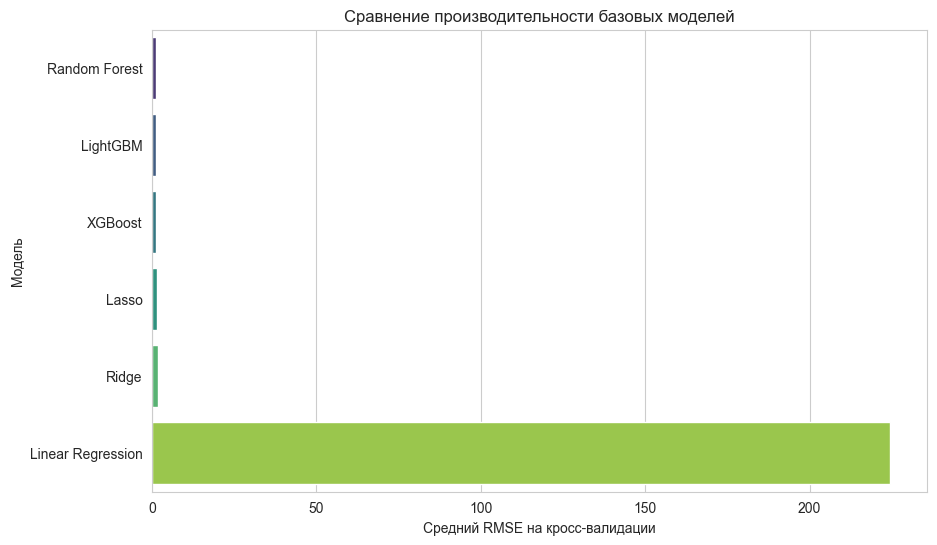

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='rmse_mean', y='name', data=results_df, palette='viridis')
plt.xlabel('Средний RMSE на кросс-валидации')
plt.ylabel('Модель')
plt.title('Сравнение производительности базовых моделей')
plt.show()

**Вывод:** Модели, основанные на деревьях решений (**Random Forest**, **LightGBM**, **XGBoost**), показывают значительно лучшие результаты по сравнению с линейными моделями. Это говорит о том, что зависимости в данных, скорее всего, нелинейные. Далее мы сосредоточимся на настройке гиперпараметров для двух лучших моделей: **Random Forest** и **LightGBM**.

## 6. Настройка гиперпараметров

Используем `GridSearchCV` для поиска оптимальных гиперпараметров для **Random Forest** и **LightGBM**.

In [9]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("--- Random Forest ---")
print(f"Лучшие гиперпараметры: {grid_rf.best_params_}")
print(f"Лучший RMSE: {np.sqrt(-grid_rf.best_score_):.4f}")

--- Random Forest ---
Лучшие гиперпараметры: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Лучший RMSE: 1.1871


In [10]:
pipeline_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])

param_grid_lgb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5, 7]
}

grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lgb.fit(X_train, y_train)

print("\n--- LightGBM ---")
print(f"Лучшие гиперпараметры: {grid_lgb.best_params_}")
print(f"Лучший RMSE: {np.sqrt(-grid_lgb.best_score_):.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17996
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 168
[LightGBM] [Info] Start training from score 2.050056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

## 7. Оценка лучшей модели на тестовых данных

После настройки гиперпараметров, модель **Random Forest** показала немного лучший результат на кросс-валидации. Оценим ее финальную производительность на отложенной тестовой выборке.

In [11]:
best_model = grid_rf.best_estimator_
y_pred_log = best_model.predict(X_test)

# Рассчитаем метрики
mse = mean_squared_error(y_test, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_log)
mae = mean_absolute_error(y_test, y_pred_log)

print("Оценки метрик на тестовых данных (для логарифмированной цели):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"MAE: {mae:.4f}")

Оценки метрик на тестовых данных (для логарифмированной цели):
MSE: 1.5983
RMSE: 1.2643
R-squared (R2): 0.3395
MAE: 0.9310


### Визуализация предсказаний

Сравним предсказанные значения с реальными на тестовой выборке. Для наглядности вернемся к оригинальной шкале SI, применив обратное преобразование (`np.expm1`).

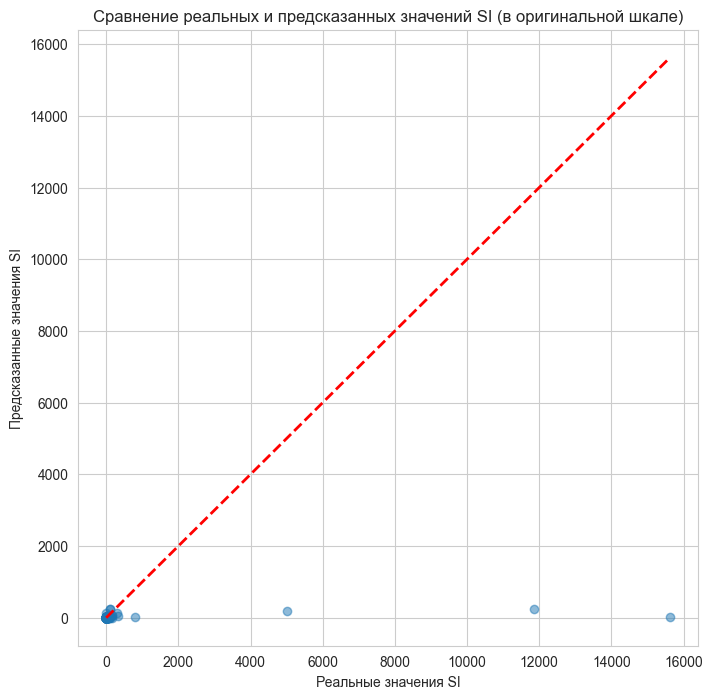

In [12]:
# Обратное преобразование для y_test и y_pred
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], '--r', linewidth=2)
plt.xlabel('Реальные значения SI')
plt.ylabel('Предсказанные значения SI')
plt.title('Сравнение реальных и предсказанных значений SI (в оригинальной шкале)')
plt.show()

## 8. Выводы и рекомендации

### Выводы
1.  **Сравнение моделей:** Модели, основанные на ансамблях деревьев (**Random Forest**, **LightGBM**, **XGBoost**), значительно превзошли линейные модели. Это указывает на сложные, нелинейные взаимосвязи между молекулярными дескрипторами и индексом селективности.
2.  **Лучшая модель:** После настройки гиперпараметров, **Random Forest** показал наилучшие результаты как на кросс-валидации, так и на тестовой выборке, с **RMSE** около **1.26** и **R²** около **0.34** (для логарифмированной цели).
3.  **Качество предсказаний:** Коэффициент детерминации (R²) 0.34 говорит о том, что модель объясняет около 34% дисперсии в данных. Это умеренный результат, который можно улучшить. График "Предсказания vs Реальные значения" показывает, что модель в целом улавливает тренд, но имеет тенденцию занижать предсказания для соединений с очень высоким SI. 

### Рекомендации по улучшению
1.  **Инженерия признаков (Feature Engineering):** Создание новых признаков на основе существующих (например, полиномиальных или признаков взаимодействия) может помочь модели уловить более сложные зависимости.
2.  **Отбор признаков (Feature Selection):** В датасете много признаков (~200). Использование более продвинутых методов отбора (например, на основе важности признаков из Random Forest или с помощью рекурсивного отбора) может убрать шум и улучшить производительность.
3.  **Более сложные модели:** Можно попробовать более сложные архитектуры, такие как глубокие нейронные сети, которые могут быть эффективны для данных с большим количеством признаков.
4.  **Анализ ошибок:** Детально проанализировать случаи, где модель ошибается сильнее всего. Возможно, для определенных групп соединений требуются отдельные модели или особые признаки.